In [ ]:
%cd /content/drive/MyDrive/KTH/course/gpu

/content/drive/MyDrive/KTH/course/gpu


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-8vlrelx_
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-8vlrelx_
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=3da5ebc8d902ef056c9e451e2be72452a640f91b78f1005955076023ab2df80a
  Stored in directory: /tmp/pip-ephem-wheel-cache-iqa3u9b2/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

directory /content/drive/MyDrive/KTH/course/gpu/src already exists
Out bin /content/drive/MyDrive/KTH/course/gpu/result.out


In [ ]:
%%cuda --name lab3_ex2.cu 


#include <stdio.h>
#include <sys/time.h>

//#define DataType double
#define DataType float

// Compute C = A * B
__global__ void gemm(DataType *A, DataType *B, DataType *C, int numARows,
                      int numAColumns, int numBRows, int numBColumns){
  //@@ Insert code to implement matrix multiplication here
  int row = blockIdx.y * blockDim.y + threadIdx.y; 
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  DataType sum = 0.;
  //printf("%d %d", col, numBColumns);
  if( col < numBColumns && row < numARows) 
  {
      for(int i = 0; i < numAColumns; i++) 
      {
          sum += A[row * numAColumns + i] * B[i * numBColumns + col];
      }
      C[row * numBColumns + col] = sum;
   //printf("%f", sum);
  }
}

//@@ Insert code to implement timer start
void timeStart(struct timeval *startt)
{
  gettimeofday(startt,NULL);
}

//@@ Insert code to implement timer stop
void timeStop(struct timeval *startt)
{
  struct timeval stopt;
  float timet;
  gettimeofday(&stopt,NULL);
  timet = (stopt.tv_usec-startt->tv_usec)*1.0e-6 + stopt.tv_sec - startt->tv_sec;
  printf("Time: %f (s)\n",timet);
}

int main(int argc, char **argv) {
  
  DataType *hostA; // The A matrix
  DataType *hostB; // The B matrix
  DataType *hostC; // The output C matrix
  DataType *resultRef; // The reference result
  DataType *deviceA;
  DataType *deviceB;
  DataType *deviceC;
  int numARows;    // number of rows in the matrix A
  int numAColumns; // number of columns in the matrix A
  int numBRows;    // number of rows in the matrix B
  int numBColumns; // number of columns in the matrix B
  int numCRows;
  int numCColumns;

  //@@ Insert code below to read in numARows, numAColumns, numBColumns from args
  sscanf(argv[1],"%d",&numARows);
  sscanf(argv[2],"%d",&numAColumns);
  sscanf(argv[3],"%d",&numBRows);
  sscanf(argv[4],"%d",&numBColumns);
  sscanf(argv[5],"%d",&numCRows);
  sscanf(argv[6],"%d",&numCColumns);
  printf("Input matrix dim (%d x %d) (%d x %d) (%d x %d)\n", numARows, numAColumns, numBRows, numBColumns, numCRows, numCColumns);
  
  
  //@@ Insert code below to allocate Host memory for input and output
  hostA = (DataType *)malloc((numARows*numAColumns)*sizeof(DataType));
  hostB = (DataType *)malloc((numBRows*numBColumns)*sizeof(DataType));
  hostC = (DataType *)malloc((numCRows*numCColumns)*sizeof(DataType));
  resultRef = (DataType *)malloc((numCRows*numCColumns)*sizeof(DataType));
  
  //@@ Insert code below to initialize hostA and hostB to random numbers, and create reference result in CPU
  for (int i = 0; i<numARows; i++)
    for (int j =0; j< numAColumns; j++)
        hostA[i*numAColumns+j] = (double) rand() / RAND_MAX;

  for (int i = 0; i<numBRows; i++)
    for (int j =0; j< numBColumns; j++)
        hostB[i*numBColumns+j] = (double) rand() / RAND_MAX;

  for (int i = 0; i<numARows; i++)
    for (int k = 0; k< numBColumns; k++)
      for (int j = 0; j< numAColumns; j++)
      {
        if (j == 0)
          resultRef[k+i*numBColumns] = hostA[i*numAColumns+j] * hostB[numBColumns*j+k];
        else
          resultRef[k+i*numBColumns] += hostA[i*numAColumns+j] * hostB[numBColumns*j+k];
      }


  //@@ Insert code below to allocate GPU memory here
  struct timeval timeh2d;
  timeStart(&timeh2d);
  cudaMalloc(&deviceA, (numARows*numAColumns)*sizeof(DataType));
  cudaMalloc(&deviceB, (numBRows*numBColumns)*sizeof(DataType));
  cudaMalloc(&deviceC, (numCRows*numCColumns)*sizeof(DataType));
  printf("H2D: ");
  timeStop(&timeh2d);

  //@@ Insert code to below to Copy memory to the GPU here
  cudaMemcpy(deviceA, hostA, numARows*numAColumns*sizeof(DataType), cudaMemcpyHostToDevice);
  cudaMemcpy(deviceB, hostB, numBRows*numBColumns*sizeof(DataType), cudaMemcpyHostToDevice);

  //@@ Initialize the grid and block dimensions here
  int BlockSize = 32; // set this value
  int grid_rows = (int)ceil((float)numARows/BlockSize);
  int grid_cols = (int)ceil((float)numBColumns/BlockSize);
  dim3 gridSize(grid_cols, grid_rows);
  dim3 blockSize(BlockSize, BlockSize);

  //@@ Launch the GPU Kernel here
  struct timeval timekernel;
  timeStart(&timekernel);
  gemm<<<gridSize, blockSize>>>(deviceA, deviceB, deviceC, numARows, numAColumns, numBRows, numBColumns);
  cudaDeviceSynchronize();
  printf("Kernel: ");
  timeStop(&timekernel);

  //@@ Copy the GPU memory back to the CPU here
  struct timeval timed2h;
  timeStart(&timed2h);
  cudaMemcpy( hostC, deviceC, (numCRows*numCColumns)*sizeof(DataType), cudaMemcpyDeviceToHost );
  printf("D2H: ");
  timeStop(&timed2h);

  //@@ Insert code below to compare the output with the reference
  for (int i = 0; i < numCRows; i++)
  {
    for (int j = 0; j < numCColumns; j++)
      //if (fabs(resultRef[i*numCColumns+j] - hostC[i*numCColumns+j])>1e-6)
      if (fabs(double(resultRef[i*numCColumns+j] - hostC[i*numCColumns+j]))>1e-3)
        printf("resultRef[%d*%d+%d]= %.3f, hostOutput[%d*%d+%d]= %.3f\n", i, numCColumns, j, resultRef[i*numCColumns+j], i, numCColumns, j, hostC[i*numCColumns+j]);
  }

  //@@ Free the GPU memory here
  cudaFree(deviceA);
  cudaFree(deviceB);
  cudaFree(deviceC);

  //@@ Free the CPU memory here
  free(hostA);
  free(hostB);
  free(hostC);
  free(resultRef);

  return 0;
}


'File written in /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2.cu'

In [ ]:
!nvcc -o /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2 /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2.cu 

In [ ]:
! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2 128 128 128 128 128 128

Input matrix dim (128 x 128) (128 x 128) (128 x 128)
H2D: Time: 0.756718 (s)
Kernel: Time: 0.000145 (s)
D2H: Time: 0.000108 (s)


In [ ]:
! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2 511 1023 1023 4094 511 4094

Input matrix dim (511 x 1023) (1023 x 4094) (511 x 4094)
H2D: Time: 0.751233 (s)
Kernel: Time: 0.048150 (s)
D2H: Time: 0.012518 (s)


In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2 128 128 128 128 128 128

Input matrix dim (128 x 128) (128 x 128) (128 x 128)
==PROF== Connected to process 584 (/content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2)
H2D: Time: 1.101639 (s)
==PROF== Profiling "gemm" - 1: 0%....50%....100% - 8 passes
Kernel: Time: 0.786268 (s)
D2H: Time: 0.000133 (s)
==PROF== Disconnected from process 584
[584] lab3_ex2@127.0.0.1
  gemm(double*, double*, double*, int, int, int, int), 2022-Dec-12 20:32:02, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           5.00
    SM Frequency                                                             cycle/usecond                         584.99
    Elapsed Cycles                                                                   cycle                         71,361
    Memory [%]                              

In [ ]:
!/usr/local/cuda-11/bin/nv-nsight-cu-cli /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2 511 1023 1023 4094 511 4094

Input matrix dim (511 x 1023) (1023 x 4094) (511 x 4094)
==PROF== Connected to process 606 (/content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2)
H2D: Time: 1.972759 (s)
==PROF== Profiling "gemm" - 1: 0%....50%....100% - 8 passes
Kernel: Time: 1.021780 (s)
D2H: Time: 0.012404 (s)
==PROF== Disconnected from process 606
[606] lab3_ex2@127.0.0.1
  gemm(double*, double*, double*, int, int, int, int), 2022-Dec-12 20:32:42, Context 1, Stream 7
    Section: GPU Speed Of Light
    ---------------------------------------------------------------------- --------------- ------------------------------
    DRAM Frequency                                                           cycle/nsecond                           5.00
    SM Frequency                                                             cycle/usecond                         585.00
    Elapsed Cycles                                                                   cycle                     28,110,280
    Memory [%]                          

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 64 128 256 512 1024 2048 
do
    ! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2 $VARIABLE $VARIABLE $VARIABLE $VARIABLE $VARIABLE $VARIABLE
done 

Input matrix dim (64 x 64) (64 x 64) (64 x 64)
H2D: Time: 0.773023 (s)
Kernel: Time: 0.000085 (s)
D2H: Time: 0.000045 (s)
Input matrix dim (128 x 128) (128 x 128) (128 x 128)
H2D: Time: 0.766345 (s)
Kernel: Time: 0.000145 (s)
D2H: Time: 0.000117 (s)
Input matrix dim (256 x 256) (256 x 256) (256 x 256)
H2D: Time: 0.780390 (s)
Kernel: Time: 0.000534 (s)
D2H: Time: 0.000420 (s)
Input matrix dim (512 x 512) (512 x 512) (512 x 512)
H2D: Time: 0.770660 (s)
Kernel: Time: 0.003368 (s)
D2H: Time: 0.001527 (s)
Input matrix dim (1024 x 1024) (1024 x 1024) (1024 x 1024)
H2D: Time: 0.762593 (s)
Kernel: Time: 0.024237 (s)
D2H: Time: 0.005959 (s)
Input matrix dim (2048 x 2048) (2048 x 2048) (2048 x 2048)
H2D: Time: 0.760342 (s)
Kernel: Time: 0.168363 (s)
D2H: Time: 0.020875 (s)


CalledProcessError: ignored

Text(0, 0.5, 'Time (s)')

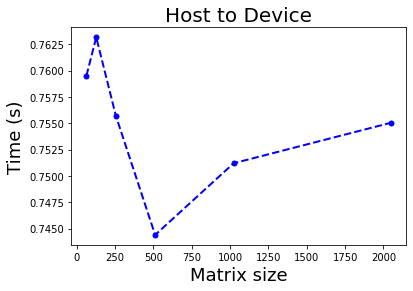

In [ ]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.759510, 0.763172, 0.755708, 0.744396, 0.751205, 0.755046], 'bo--', linewidth=2, markersize=5)
plt.title('Host to Device', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

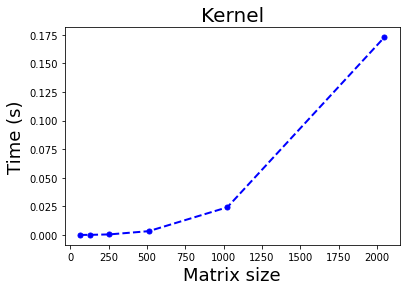

In [ ]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.000086, 0.000144, 0.000538, 0.003367, 0.024233, 0.172788], 'bo--', linewidth=2, markersize=5)
plt.title('Kernel', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

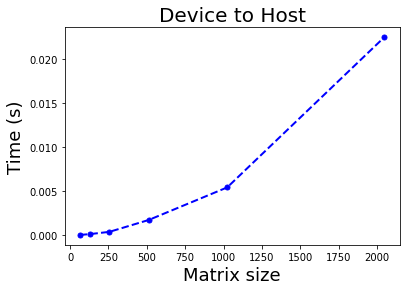

In [ ]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.000048, 0.000137, 0.000396, 0.001744, 0.005447, 0.022513], 'bo--', linewidth=2, markersize=5)
plt.title('Device to Host', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

float

In [ ]:
%%shell 
#!/bin/bash
for VARIABLE in 64 128 256 512 1024 2048
do
    ! /content/drive/MyDrive/KTH/course/gpu/src/lab3_ex2 $VARIABLE $VARIABLE $VARIABLE $VARIABLE $VARIABLE $VARIABLE
done           

Input matrix dim (64 x 64) (64 x 64) (64 x 64)
H2D: Time: 0.662763 (s)
Kernel: Time: 0.000042 (s)
D2H: Time: 0.000031 (s)
Input matrix dim (128 x 128) (128 x 128) (128 x 128)
H2D: Time: 0.663270 (s)
Kernel: Time: 0.000057 (s)
D2H: Time: 0.000065 (s)
Input matrix dim (256 x 256) (256 x 256) (256 x 256)
H2D: Time: 0.661198 (s)
Kernel: Time: 0.000163 (s)
D2H: Time: 0.000214 (s)
Input matrix dim (512 x 512) (512 x 512) (512 x 512)
H2D: Time: 0.687502 (s)
Kernel: Time: 0.000973 (s)
D2H: Time: 0.000826 (s)
Input matrix dim (1024 x 1024) (1024 x 1024) (1024 x 1024)
H2D: Time: 0.723285 (s)
Kernel: Time: 0.006756 (s)
D2H: Time: 0.003258 (s)
Input matrix dim (2048 x 2048) (2048 x 2048) (2048 x 2048)
H2D: Time: 0.672863 (s)
Kernel: Time: 0.053114 (s)
D2H: Time: 0.010860 (s)


CalledProcessError: ignored

Text(0, 0.5, 'Time (s)')

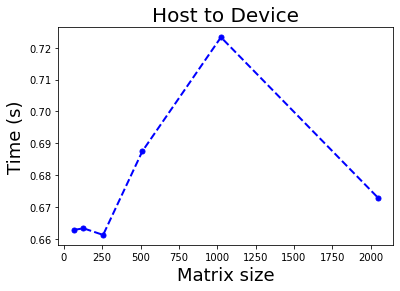

In [ ]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.662763, 0.663270, 0.661198, 0.687502, 0.723285, 0.672863], 'bo--', linewidth=2, markersize=5)
plt.title('Host to Device', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

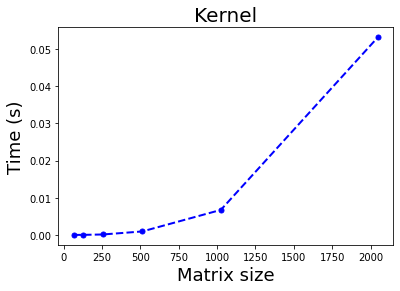

In [ ]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.000042, 0.000057, 0.000163, 0.000973, 0.006756, 0.053114], 'bo--', linewidth=2, markersize=5)
plt.title('Kernel', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)

Text(0, 0.5, 'Time (s)')

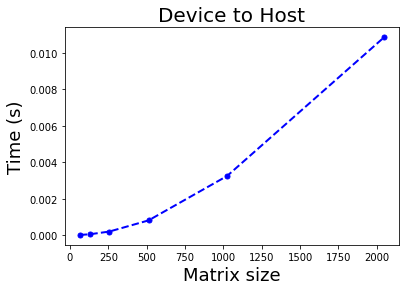

In [ ]:
import matplotlib.pyplot as plt

plt.plot([64, 128, 256, 512, 1024, 2048],[0.000031, 0.000065, 0.000214, 0.000826, 0.003258, 0.010860], 'bo--', linewidth=2, markersize=5)
plt.title('Device to Host', fontsize=20)
plt.xlabel('Matrix size', fontsize=18)
plt.ylabel('Time (s)', fontsize=18)